<a href="https://colab.research.google.com/github/Faiqazmi/RepoTugasBesar_TKC_047_059/blob/main/Tugas_6_TKC_047_059.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files #import lib
from pathlib import Path
import os
import pandas as pd
import json
import zipfile
import matplotlib.pyplot as plt

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}'}

In [3]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: #membuka file kaggle.json yang telah diupload
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!mkdir -p ~/.kaggle #membuat directory bernama kaggle 
!cp kaggle.json ~/.kaggle/ #copy file kaggle.json upload tadi ke directory baru
!chmod 600 ~/.kaggle/kaggle.json #berikan izin untuk file kaggle.json

In [5]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [01:21<00:00, 55.0MB/s]
100% 3.24G/3.24G [01:22<00:00, 42.5MB/s]


In [6]:
from zipfile import ZipFile #library
file_name = "a-large-scale-fish-dataset.zip" #nama file yang telah di download

with ZipFile(file_name,'r') as zip : #file dibaca dengan alias zip
  zip.extractall() #ini kalo gk salah buat tempat hasil nya. karena gak ada, ya default ke content
  print('Berhasil') #ini print

Berhasil


In [7]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))

# create labels from the folder name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [8]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
1,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
2,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
3,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
4,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat


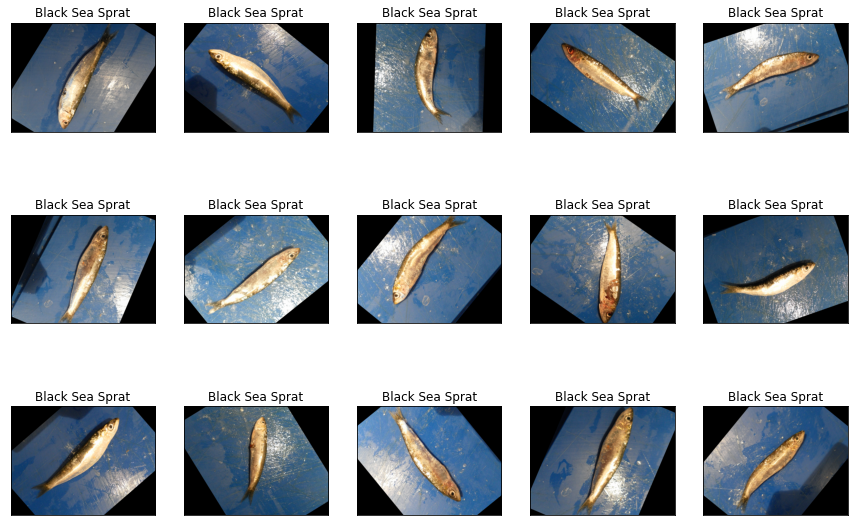

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [10]:
df.label.value_counts()

Red Sea Bream            1000
Black Sea Sprat          1000
Trout                    1000
Gilt-Head Bream GT       1000
Shrimp                   1000
Sea Bass GT              1000
Red Sea Bream GT         1000
Shrimp GT                1000
Red Mullet               1000
Hourse Mackerel          1000
Red Mullet GT            1000
Striped Red Mullet GT    1000
Hourse Mackerel GT       1000
Gilt-Head Bream          1000
Sea Bass                 1000
Black Sea Sprat GT       1000
Striped Red Mullet       1000
Trout GT                 1000
Name: label, dtype: int64

In [11]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Striped Red Mullet    1000
Red Sea Bream         1000
Black Sea Sprat       1000
Sea Bass              1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Shrimp                1000
Trout                 1000
Name: label, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

In [13]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [14]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [15]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [16]:
input_shape = (200, 200, 3)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [18]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
158/158 [==============================] - 132s 757ms/step - loss: 2.0385 - accuracy: 0.1956 - val_loss: 1.9191 - val_accuracy: 0.2381
Epoch 2/100
158/158 [==============================] - 117s 739ms/step - loss: 1.6730 - accuracy: 0.3054 - val_loss: 1.4559 - val_accuracy: 0.4302
Epoch 3/100
158/158 [==============================] - 117s 739ms/step - loss: 1.3736 - accuracy: 0.4347 - val_loss: 1.3592 - val_accuracy: 0.4690
Epoch 4/100
158/158 [==============================] - 117s 743ms/step - loss: 1.1622 - accuracy: 0.5244 - val_loss: 0.9902 - val_accuracy: 0.6103
Epoch 5/100
158/158 [==============================] - 116s 737ms/step - loss: 0.9798 - accuracy: 0.5952 - val_loss: 0.8368 - val_accuracy: 0.6635
Epoch 6/100
158/158 [==============================] - 117s 739ms/step - loss: 0.8022 - accuracy: 0.6790 - val_loss: 0.6619 - val_accuracy: 0.7397
Epoch 7/100
158/158 [==============================] - 117s 738ms/step - loss: 0.7344 - accuracy: 0.7109 - val_loss: 0

In [19]:
model.save('model-fish1.h5')

In [20]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

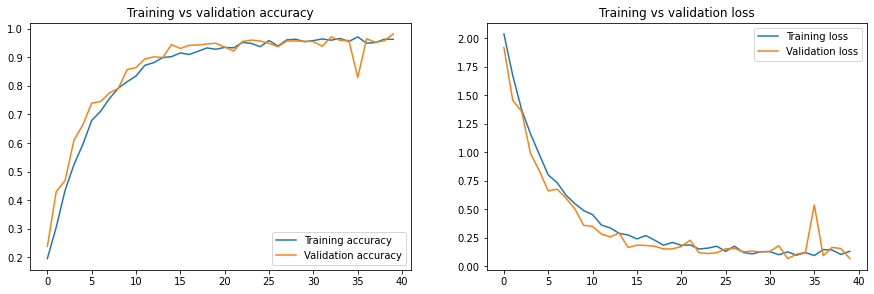

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [22]:
pred = model.predict(test)

In [23]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [24]:
labels = train.class_indices
labels

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [25]:
labels = dict((v,k) for k, v in labels.items())
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [26]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      0.99      0.99       305
   Gilt-Head Bream       0.96      0.93      0.94       321
   Hourse Mackerel       0.99      0.99      0.99       314
        Red Mullet       1.00      0.98      0.99       298
     Red Sea Bream       0.97      0.97      0.97       301
          Sea Bass       0.97      0.96      0.97       293
            Shrimp       1.00      1.00      1.00       290
Striped Red Mullet       0.97      1.00      0.98       287
             Trout       0.95      1.00      0.97       291

          accuracy                           0.98      2700
         macro avg       0.98      0.98      0.98      2700
      weighted avg       0.98      0.98      0.98      2700



In [27]:
print(confusion_matrix(x_test.label, y_pred))

[[302   0   1   0   0   2   0   0   0]
 [  0 298   0   0   8   3   0   0  12]
 [  2   0 310   0   0   2   0   0   0]
 [  0   0   0 293   0   0   0   5   0]
 [  0   8   0   0 293   0   0   0   0]
 [  2   5   0   0   0 281   0   3   2]
 [  0   0   0   0   0   0 289   1   0]
 [  0   0   1   0   0   0   0 286   0]
 [  0   0   0   0   0   1   0   0 290]]


In [28]:
test_accuracy = model.evaluate(test)[1]

85/85 [==============================] - 50s 582ms/step - loss: 0.0657 - accuracy: 0.9763
